In [5]:
!pip install tensorflow
!pip install matplotlib

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [7]:
# Function to generate random 3D voxel data (reduced to 500 samples)- can be increased as per requirements
def generate_voxel_data(shape=(32, 32, 32), num_samples=500):
    """
    Generate random 3D voxel data as a simple dataset for GAN.
    """
    data = []
    for _ in range(num_samples):
        voxels = np.random.rand(*shape)
        data.append((voxels > 0.5).astype(int))
    return np.array(data)

# We now generate voxel data
voxel_data = generate_voxel_data()

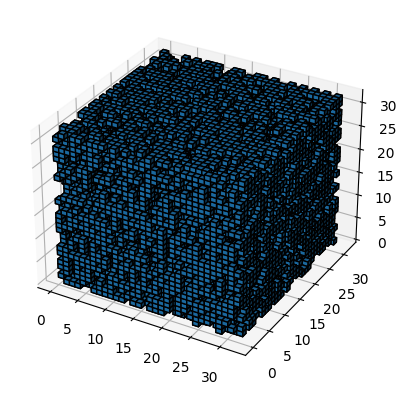

In [8]:
# We now visualize one voxel sample (optional)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(voxel_data[0], edgecolor='k')
plt.show()

In [55]:
# Define the generator model
# Define the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(1024, input_dim=150)) # Changed the number of neurons to 1024
    model.add(Reshape((4, 4, 4, 16)))
    model.add(Conv3DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(Conv3DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(Conv3DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid'))
    return model

In [56]:
# Define the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv3D(32, kernel_size=4, strides=2, padding='same', input_shape=(32, 32, 32, 1)))
    model.add(Conv3D(64, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [64]:
# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(150,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5)) # Use learning_rate instead of lr
    return gan

In [65]:
# Training function
def train_gan(gan, generator, discriminator, voxel_data, epochs=100, batch_size=8):
    for epoch in range(epochs):
        # Generate random noise for the generator
        noise = np.random.normal(0, 1, (batch_size, 150))

        # Generate fake voxels
        generated_voxels = generator.predict(noise)

        # Get real voxel samples from the dataset
        real_voxels = voxel_data[np.random.randint(0, voxel_data.shape[0], batch_size)]

        # Add noise to the generated voxels
        generated_voxels = add_noise_to_voxels(generated_voxels)

        # Labels for real and fake data
        real_labels = np.ones((batch_size, 1)) * 0.9
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator on real data
        d_loss_real = discriminator.train_on_batch(real_voxels, real_labels)

        # Train the discriminator on fake data
        d_loss_fake = discriminator.train_on_batch(generated_voxels, fake_labels)

        # Calculate discriminator loss
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        # Train the GAN with noise as input and real labels
        g_loss = gan.train_on_batch(noise, real_labels)

        # Print losses every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Generator Loss: {g_loss}, Discriminator Loss: {d_loss}")

In [66]:
# Define the noise addition function
def add_noise_to_voxels(voxels, noise_factor=0.1):
    noise = np.random.normal(0, noise_factor, voxels.shape)
    return np.clip(voxels + noise, 0.0, 1.0)



In [67]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv3DTranspose, BatchNormalization, Activation, Conv3D, Flatten, Input
from keras.optimizers import Adam
import numpy as np
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv3DTranspose, BatchNormalization, Activation, Conv3D, Flatten, Input
from keras.optimizers import Adam
import numpy as np

# Assuming you have defined the build_generator and build_discriminator functions elsewhere
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator model
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5)) # Compile the discriminator

gan = build_gan(generator, discriminator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
train_gan(gan, generator, discriminator, voxel_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, Generator Loss: [array(0.6997949, dtype=float32), array(0.6997949, dtype=float32)], Discriminator Loss: 0.733644962310791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epoch 10, Generator Loss: [array(0.70051694, dtype=float32), array(0.70051694, dtype=float32)], Discriminator Loss: 0.7020827531814575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [75]:
def generate_samples(generator, num_samples=10, latent_dim=150):
    """
    Generate new voxel samples using the trained generator.
    """
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_voxels = generator.predict(noise)
    return generated_voxels

# Generate new samples
num_samples = 5
generated_voxels = generate_samples(generator, num_samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


In [77]:
print(generated_voxels.shape)


(5, 32, 32, 32, 1)


In [81]:
def plot_voxels(voxels, num_samples=5):
    """
    Plot a grid of 3D voxel samples.
    """
    fig = plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        ax = fig.add_subplot(1, num_samples, i + 1, projection='3d')
        voxel_data = voxels[i, ..., 0]  # Remove channel dimension if present
        ax.voxels(voxel_data, edgecolor='k',facecolors='yellow')
        ax.set_title(f'Sample {i+1}')
    plt.show()


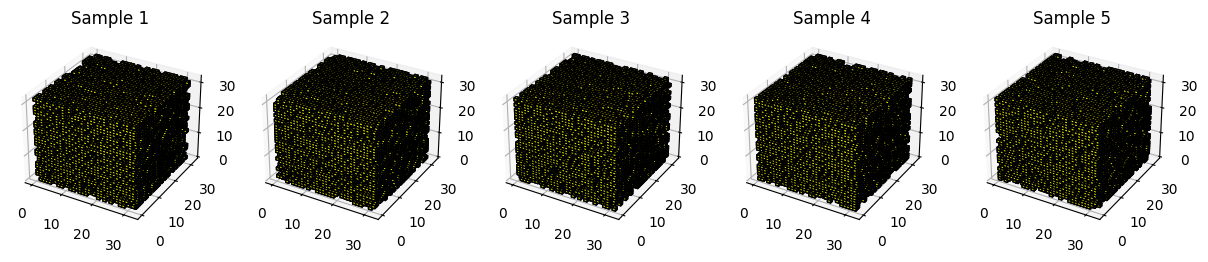

In [82]:
# Generate sample data for testing
num_samples = 5
test_voxels = np.random.randint(0, 2, (num_samples, 32, 32, 32, 1))

# Plot the test voxels
plot_voxels(test_voxels, num_samples)

In [83]:
# Print the summary of the generator model
generator.summary()

# Access and print the weights and biases of each layer
for layer in generator.layers:
    print(f"Layer Name: {layer.name}")
    if layer.get_weights():
        weights, biases = layer.get_weights()
        print(f"  Weights shape: {weights.shape}")
        print(f"  Biases shape: {biases.shape}")
        # You can print a few sample values for inspection
        print(f"  Sample weights: {weights[:5]}")
        print(f"  Sample biases: {biases[:5]}")
    else:
        print("  No weights or biases for this layer.")

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 1024)                │         154,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 4, 4, 4, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_18                  │ (None, 8, 8, 8, 64)         │          65,600 │
│ (Conv3DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_19                  │ (None, 16, 16, 16, 32)      │         131,104 │
│ (Conv3DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_transpose_20                  │ (None, 32, 32, 32, 1)       │           2,049 │
│ (Conv3DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 353,377 (1.35 MB)

 Trainable params: 353,377 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Layer Name: dense_11
  Weights shape: (150, 1024)
  Biases shape: (1024,)
  Sample weights: [[ 0.07185303  0.06524426  0.07375583 ...  0.05891489  0.01358127
   0.03697716]
 [ 0.0455436   0.01003439  0.01180207 ...  0.00324969 -0.01710569
  -0.00150309]
 [-0.00313397  0.06752088  0.04336544 ... -0.01548398 -0.0062384
   0.06136793]
 [-0.06524641 -0.01102959  0.07446443 ...  0.01920437  0.02943945
  -0.06383642]
 [ 0.0431999  -0.05327532  0.01837887 ... -0.02689143  0.00682941
   0.01708768]]
  Sample biases: [-0.01792555 -0.01649897 -0.0087643  -0.02979534  0.02105622]
Layer Name: reshape_7
  No weights or biases for this layer.
Layer Name: conv3d_transpose_18
  Weights shape: (4, 4, 4, 64, 16)
  Biases shape: (64,)
  Sample weights: [[[[[-3.31277698e-02 -2.93473024e-02 -3.04422043e-02 ...
      3.83028761e-02  8.03147792e-04 -2.72965282e-02]
    [-8.13662447e-03 -3.07197426e-03  3.40580917e-03 ...
     -3.49422544e-02  1.34296743e-02 -4.09453921e-02]
    [ 3.57290171e-02  3.70383188e-

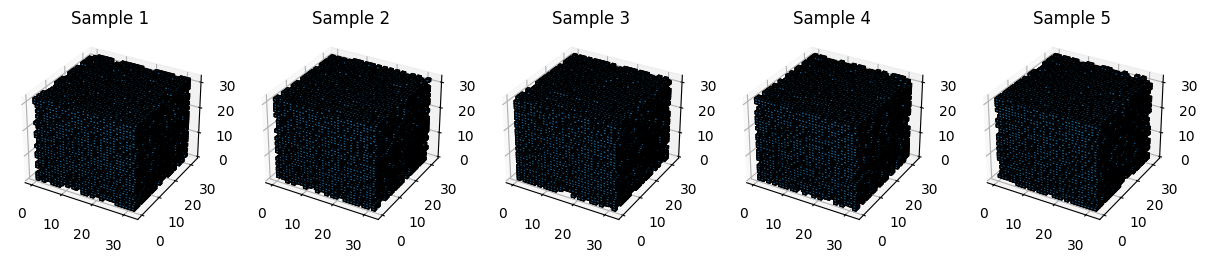

In [80]:
# Generate sample data for testing
num_samples = 5
test_voxels = np.random.randint(0, 2, (num_samples, 32, 32, 32, 1))

# Plot the test voxels
plot_voxels(test_voxels, num_samples)


In [87]:
generator.save('generator_model.h5')